In [1]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sp_flat = openmc.StatePoint('./flat_study/statepoint.100.h5')
sp_minimized = openmc.StatePoint('./most_minimized/statepoint.100.h5')

In [4]:
sp_flat.k_combined

1.3901187596140854+/-0.0006907775466662456

In [5]:
sp_minimized.k_combined

1.391983611676469+/-0.0007636295816801844

In [6]:
sp_minimized.k_combined.n / sp_flat.k_combined.n

1.0013415055724457

In [7]:
def get_ppf_fuel(sp, pf_z):
    mesh_tally = sp.get_tally(name='fqr')
    fqro = mesh_tally.get_slice(scores=['fission-q-recoverable'])
    nu_fission = mesh_tally.get_slice(scores=['nu-fission'])
    fission = mesh_tally.get_slice(scores=['fission'])
    fqro_list = fqro.mean
    fqro_list.shape = (5,10)
    fqro_array = np.array(fqro_list)
    pf = [pf_z] * 5
    pf_array = np.array(pf_z)
    ppf = np.max((fqro_array/ pf_array))/ np.mean(fqro_array/ pf_array)
    return ppf

In [8]:
get_ppf_fuel(sp_flat, [0.0232]*10)

1.0637213896243356

In [9]:
total_pf_minimized = [0.00243119,0.04654394,0.00181097,0.04545775, 0.00456214,0.04114655,0.01026891,0.0342619,0.01806882,0.02584428]
get_ppf_fuel(sp_minimized, total_pf_minimized)

1.363544622636563

In [10]:
def flux_total(sp):
    tally_flux_all = sp.get_tally(name='flux_all')
    flux_all = tally_flux_all.get_slice(scores=['flux'])
    nu_fission_all = tally_flux_all.get_slice(scores=['nu-fission'])
    fission_all = tally_flux_all.get_slice(scores=['fission'])
    nu = sum(nu_fission_all.mean) / sum(fission_all.mean)
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * 1 / (100 * 20)
    k = sp.k_combined.n
    P = 1456
    N = P * nu / (Q * k)
    flux_all_vals = flux_all.mean * 1 / V * N
    flux_all_vals.shape = (20, 100)
    return flux_all_vals

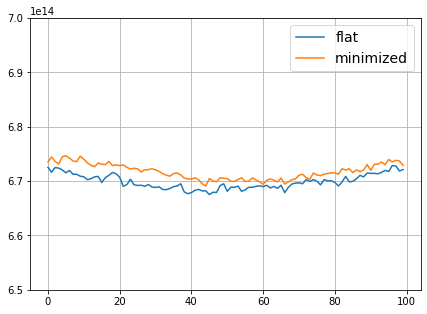

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(flux_total(sp_flat)[10], label="flat")
ax.plot(flux_total(sp_minimized)[10], label="minimized")
ax.set_ylim(6.5e14, 7e14)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])

In [12]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu, nu_fiss_eg, fiss_eg = {}, {}, {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg[x] = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg[x] = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg[x].mean) / sum(fiss_eg[x].mean)
    return flux_eg, nu, nu_fiss_eg, fiss_eg

In [13]:
def get_flux_dict_plank(k, P, z_thickness, nu, flux_eg):
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * z_thickness / (100 * 20)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (20, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [14]:
flux_eg_flat, nu_flat, nu_fiss_flat, fiss_eg_flat = get_values(sp_flat)

0
1
2
3


In [15]:
flux_eg_minimized, nu_minimized, nu_fiss_minimized, fiss_eg_minimized = get_values(sp_minimized)

0
1
2
3


In [16]:
def get_fiss_dict(fiss_eg):
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    fiss_dict = {}
    for x in range(4):
        fiss_dict[eg_names[x]] = fiss_eg[x].mean
        fiss_dict[eg_names[x]].shape = (20, 100)
    return fiss_dict

In [17]:
fiss_dict_flat = get_fiss_dict(fiss_eg_flat)
fiss_dict_minimized = get_fiss_dict(fiss_eg_minimized)
nu_fiss_dict_flat = get_fiss_dict(nu_fiss_flat)
nu_fiss_dict_minimized = get_fiss_dict(nu_fiss_minimized)

In [18]:
def total_perc(flat, minimized):
    total_flat = 0
    perc_flat = {}
    for i in range(1,5):
        total_flat += sum(sum(flat["eg"+str(i)]))
    for i in range(1,5):
        perc_flat["eg"+str(i)] = sum(sum(flat["eg"+str(i)])) / total_flat * 100
    total_minimized = 0
    perc_minimized = {}
    for i in range(1,5):
        total_minimized += sum(sum(minimized["eg"+str(i)]))
    for i in range(1,5):
        perc_minimized["eg"+str(i)] = sum(sum(minimized["eg"+str(i)])) / total_minimized * 100
    print(perc_flat)
    print(perc_minimized)

In [19]:
# NU-FISSION

In [20]:
total_perc(nu_fiss_dict_flat, nu_fiss_dict_minimized)

{'eg1': 0.23065005206107922, 'eg2': 1.1662115517535256, 'eg3': 1.153590428331244, 'eg4': 97.44954796785416}
{'eg1': 0.23522013290155808, 'eg2': 1.16331616851946, 'eg3': 1.149058001292467, 'eg4': 97.45240569728651}


0.003275361452540389 0.0032060030923971327
1.0216339030700674


Text(0.5, 1.0, 'Nu-Fission Group 1')

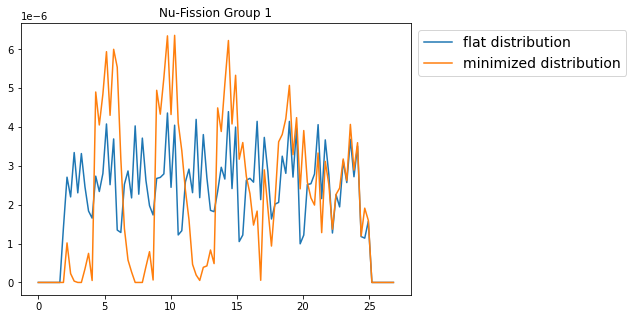

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, nu_fiss_dict_flat['eg1'][10], label="flat distribution")
ax.plot(x, nu_fiss_dict_minimized['eg1'][10], label="minimized distribution")
print(sum(sum(nu_fiss_dict_minimized['eg1'])), sum(sum(nu_fiss_dict_flat['eg1'])))
print(sum(sum(nu_fiss_dict_minimized['eg1']))/sum(sum(nu_fiss_dict_flat['eg1'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Nu-Fission Group 1")
# minimized distribution has a higher neutron reproduction factor (thus, higher keff)

0.01619878744427144 0.016210175579413948
0.9992974699696053


Text(0.5, 1.0, 'Nu-Fission Group 2')

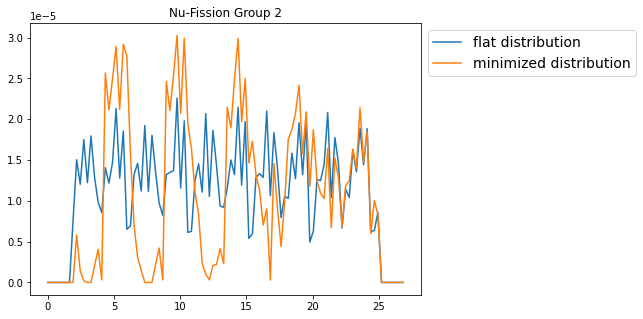

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, nu_fiss_dict_flat['eg2'][10], label="flat distribution")
ax.plot(x, nu_fiss_dict_minimized['eg2'][10], label="minimized distribution")
print(sum(sum(nu_fiss_dict_minimized['eg2'])), sum(sum(nu_fiss_dict_flat['eg2'])))
print(sum(sum(nu_fiss_dict_minimized['eg2']))/sum(sum(nu_fiss_dict_flat['eg2'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Nu-Fission Group 2")

0.016000247248144975 0.016034743749419624
0.9978486403141992


Text(0.5, 1.0, 'Nu-Fission Group 3')

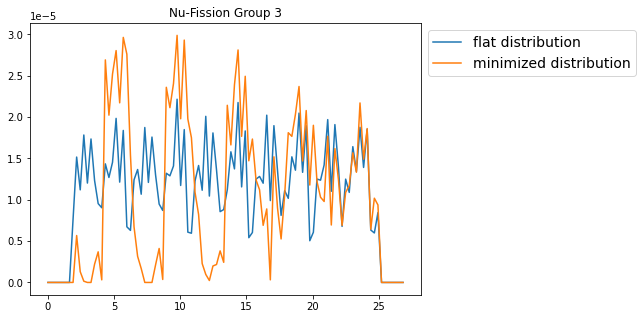

In [23]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, nu_fiss_dict_flat['eg3'][10], label="flat distribution")
ax.plot(x, nu_fiss_dict_minimized['eg3'][10], label="minimized distribution")
print(sum(sum(nu_fiss_dict_minimized['eg3'])), sum(sum(nu_fiss_dict_flat['eg3'])))
print(sum(sum(nu_fiss_dict_minimized['eg3']))/sum(sum(nu_fiss_dict_flat['eg3'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Nu-Fission Group 3")

1.3569920616098134 1.3545349300632683
1.0018140038267085


Text(0.5, 1.0, 'Nu-Fission Group 4')

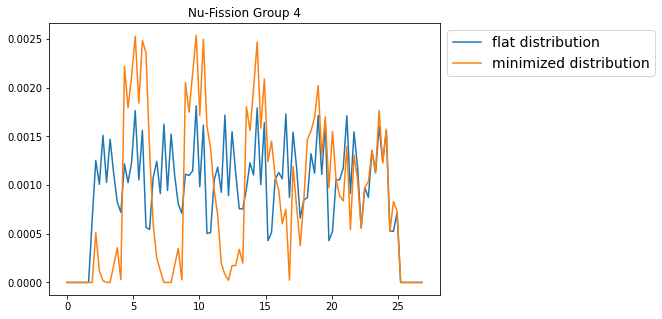

In [24]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, nu_fiss_dict_flat['eg4'][10], label="flat distribution")
ax.plot(x, nu_fiss_dict_minimized['eg4'][10], label="minimized distribution")
print(sum(sum(nu_fiss_dict_minimized['eg4'])), sum(sum(nu_fiss_dict_flat['eg4'])))
print(sum(sum(nu_fiss_dict_minimized['eg4']))/sum(sum(nu_fiss_dict_flat['eg4'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Nu-Fission Group 4")

In [25]:
# FISSION

In [26]:
total_perc(fiss_dict_flat, fiss_dict_minimized)

{'eg1': 0.21645621294160752, 'eg2': 1.1673925856105425, 'eg3': 1.153800822563582, 'eg4': 97.46235037888427}
{'eg1': 0.22055161596410425, 'eg2': 1.1645003142192563, 'eg3': 1.1492729940278312, 'eg4': 97.46567507578881}


0.0012601835017263128 0.0012345859145378262
minimized/flat 1.0207337431012804
% 2.0733743101280453


Text(0.5, 1.0, 'Fission Group 1')

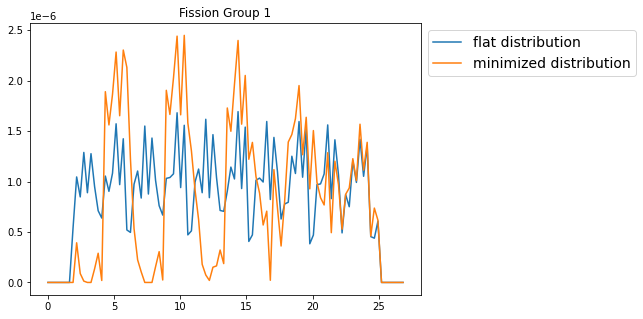

In [27]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg1'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg1'][10], label="minimized distribution")
minimized_sum = sum(sum(fiss_dict_minimized['eg1']))
minimized_flat = sum(sum(fiss_dict_flat['eg1']))
print(minimized_sum, minimized_flat)
print("minimized/flat", minimized_sum/minimized_flat)
print("%", (minimized_sum-minimized_flat)/minimized_flat*100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 1")

0.006653699077739034 0.006658374104140258
minimized/flat 0.9992978726746042
% -0.07021273253957137


Text(0.5, 1.0, 'Fission Group 2')

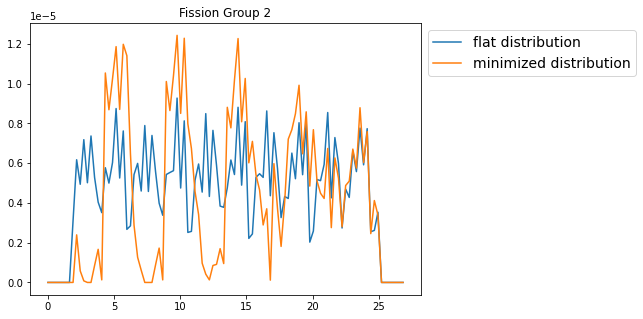

In [28]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg2'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg2'][10], label="minimized distribution")
minimized_sum = sum(sum(fiss_dict_minimized['eg2']))
minimized_flat = sum(sum(fiss_dict_flat['eg2']))
print(minimized_sum, minimized_flat)
print("minimized/flat", minimized_sum/minimized_flat)
print("%", (minimized_sum-minimized_flat)/minimized_flat*100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 2")

0.0065666935139989755 0.00658085173144662
minimized/flat 0.9978485737066543
% -0.21514262933457737


Text(0.5, 1.0, 'Fission Group 3')

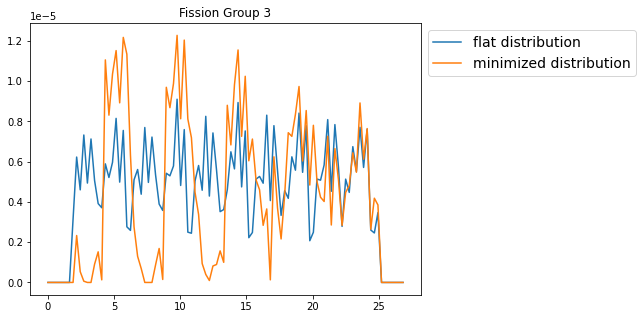

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg3'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg3'][10], label="minimized distribution")
minimized_sum = sum(sum(fiss_dict_minimized['eg3']))
minimized_flat = sum(sum(fiss_dict_flat['eg3']))
print(minimized_sum, minimized_flat)
print("minimized/flat", minimized_sum/minimized_flat)
print("%", (minimized_sum-minimized_flat)/minimized_flat*100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 3")

0.5568974644697993 0.5558890795524571
minimized/flat 1.001814003826364
% 0.18140038263640013


Text(0.5, 1.0, 'Fission Group 4')

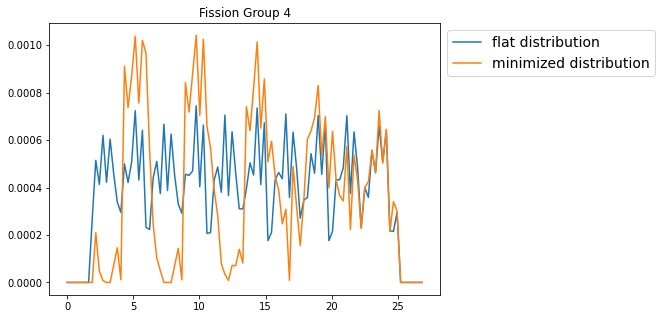

In [30]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg4'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg4'][10], label="minimized distribution")
minimized_sum = sum(sum(fiss_dict_minimized['eg4']))
minimized_flat = sum(sum(fiss_dict_flat['eg4']))
print(minimized_sum, minimized_flat)
print("minimized/flat", minimized_sum/minimized_flat)
print("%", (minimized_sum-minimized_flat)/minimized_flat*100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 4")
# Higher fission reaction rate 

In [31]:
power_moltres = 1456 # 1cm thick
flux_vals_flat = get_flux_dict_plank(sp_flat.k_combined.n, power_moltres, z_thickness=1, nu=nu_flat, flux_eg=flux_eg_flat)
flux_vals_minimized = get_flux_dict_plank(sp_minimized.k_combined.n, power_moltres, z_thickness=1, nu=nu_minimized, flux_eg=flux_eg_minimized)



In [32]:
def plot_flux(group, bot, top):
    x = np.arange(0, 27.1, 27.1/100)
    flux_flat = np.array(flux_vals_flat['eg'+str(group)][10])
    flux_minimized = np.array(flux_vals_minimized['eg'+str(group)][10])
    print("flat", max(flux_vals_flat['eg'+str(group)][10]) / min(flux_vals_flat['eg'+str(group)][10]))
    print("min", max((flux_vals_minimized['eg'+str(group)][10]))/ min((flux_vals_minimized['eg'+str(group)][10])))
    minimized_sum = sum(sum(flux_vals_minimized['eg'+str(group)]))
    minimized_flat = sum(sum(flux_vals_flat['eg'+str(group)]))
    print("sum(minimized) / sum(flat)", minimized_sum/minimized_flat)
    print("%", (minimized_sum-minimized_flat)/minimized_flat*100)
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(x, flux_flat, label="flat distribution")
    ax.plot(x, flux_minimized, label=r'most-minimized $PPF_{fuel}$ distribution')
    ax.set_ylim(bot, top)
    ax.set_xlabel('x [cm]', fontsize=16)
    ax.set_ylabel(r'Flux [$n/cm^2s$]', fontsize=16)
    ax.set_title("group "+str(group)+", sum(minimized flux)/sum(flat flux): "+\
                 str(sum(sum(flux_vals_minimized['eg'+str(group)]))/sum(sum(flux_vals_flat['eg'+str(group)]))))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
    ax.grid()
    ax.set_xlim(0, 27.1)
    plt.savefig("flux-comparison-0.023-plank_grp"+str(group)+".png",bbox_inches='tight')

flat 1.1451423938132472
min 1.266730268041143
sum(minimized) / sum(flat) 0.9993018587255736
% -0.06981412744263475


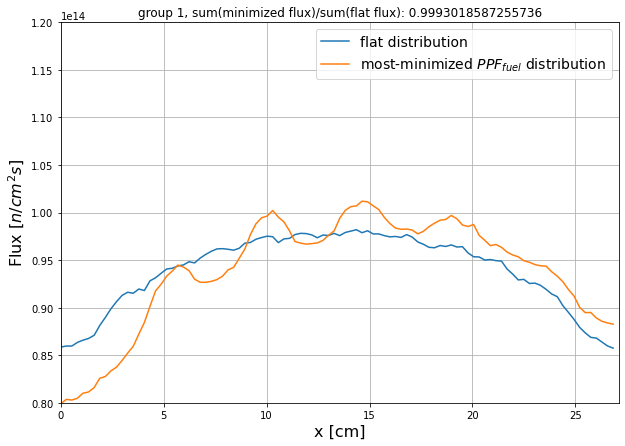

In [33]:
plot_flux(1, 0.8e14, 1.2e14)

flat 1.014278230668564
min 1.0353508521295591
sum(minimized) / sum(flat) 0.9982604998103349
% -0.17395001896650789


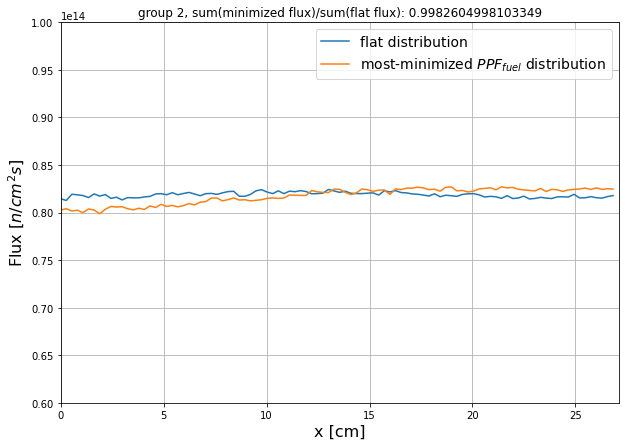

In [34]:
plot_flux(2, 0.6e14, 1e14)

flat 1.0370166433788908
min 1.042413372285321
sum(minimized) / sum(flat) 1.0004177902543514
% 0.04177902543514765


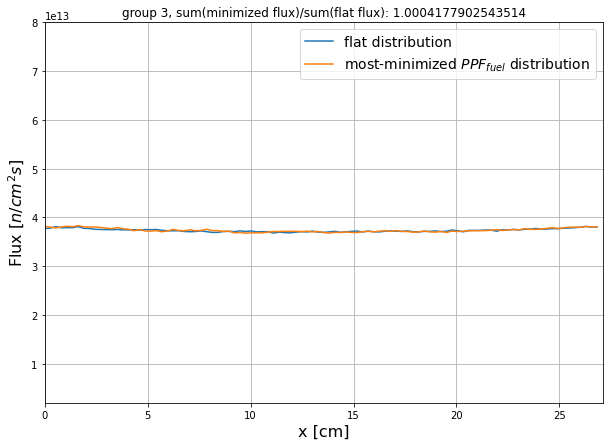

In [35]:
plot_flux(3, 0.2e13, 0.8e14)

flat 1.0347612756489475
min 1.0545878037177625
sum(minimized) / sum(flat) 1.0045301784131524
% 0.4530178413152344


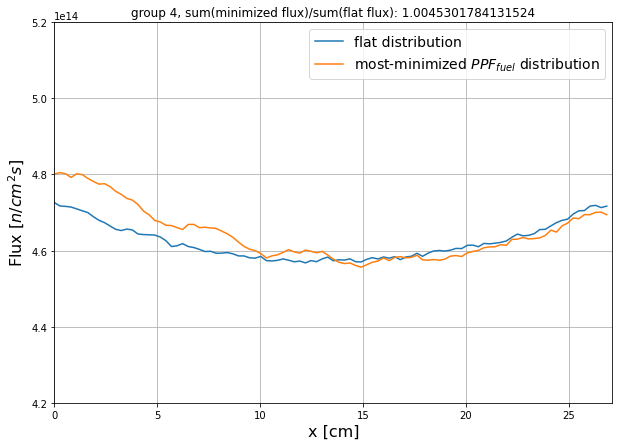

In [36]:
plot_flux(4, 4.2e14, 5.2e14) 